In [1]:
# !pip install -q mnists equinox

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from jaxtyping import Array, Float, Int, PyTree
import jax.tree_util as jtu

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [179]:
import mnists
import numpy as np
from sklearn.model_selection import train_test_split


def prepare_dataset(dataset):
    X_train = dataset.train_images().astype(np.float32)[:, None, :] / 255.0
    y_train = dataset.train_labels().astype(np.int32)
    X_test = dataset.test_images().astype(np.float32)[:, None, :] / 255.0
    y_test = dataset.test_labels().astype(np.int32)
    return X_train, y_train, X_test, y_test

def unison_permute(*args, seed=0):
    assert all(len(x) == len(args[0]) for x in args)

    rng = np.random.default_rng(seed)
    idxs = jnp.arange(len(args[0]))

    return tuple(x[idxs] for x in args)


dataset = mnists.EMNIST().Balanced()
X_train, y_train, X_test, y_test = prepare_dataset(dataset)
# y_train -= 1
# y_test -= 1

X_train, y_train = unison_permute(X_train, y_train, seed=0)
X_test, y_test = unison_permute(X_test, y_test, seed=1)

# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train, y_train, test_size=0.1, random_state=0,
# )

BATCH_SIZE = 512
NUM_CLASSES = len(dataset.classes)
X_train.shape, X_test.shape

((112800, 1, 28, 28), (18800, 1, 28, 28))

In [180]:
min(y_train), max(y_train)

(0, 46)

In [173]:
def batch_data(*args, batch_size, enum=False, shorten=False):
    assert shorten or all(len(x) == len(args[0]) for x in args)
    n = min(len(x) for x in args)
    for i in range(0, n, batch_size):
        if enum:
            yield (i, *(x[i:i+batch_size] for x in args))
        else:
            yield (x[i:i+batch_size] for x in args)

_i, X_dummy, y_dummy = next(iter(batch_data(X_train, y_train, enum=True, batch_size=BATCH_SIZE)))
X_dummy.shape, y_dummy.shape, type(X_dummy), _i

((512, 1, 28, 28), (512,), numpy.ndarray, 0)

In [174]:
def tiles(examples, title=""):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]

    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = examples[r, c]

    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.title(title)

(60000, 1, 28, 28)


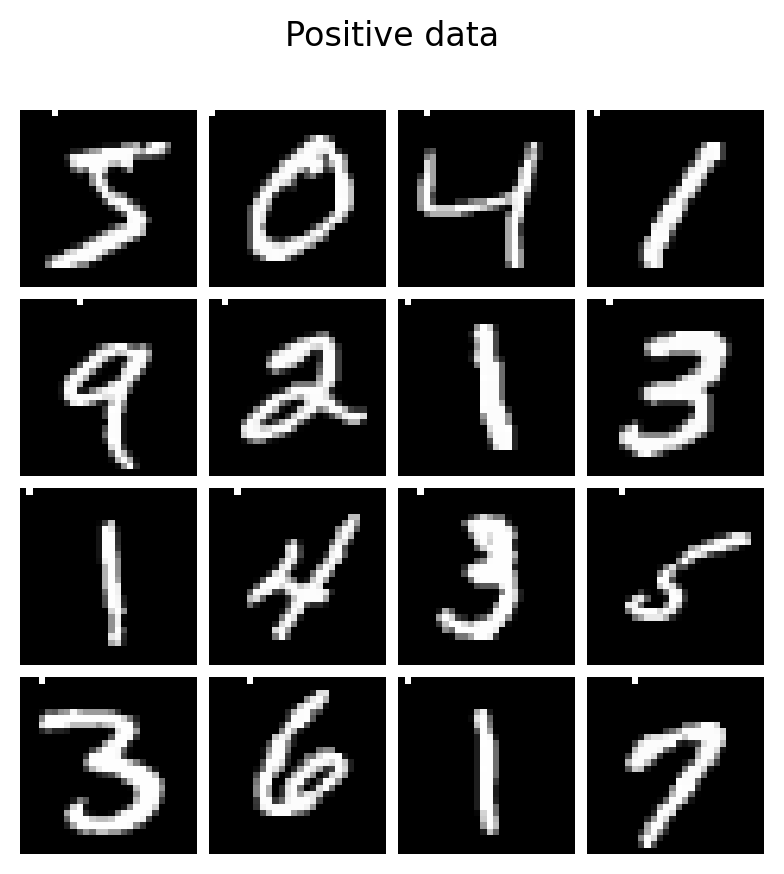

In [175]:
def jnp_encode_class_in_image(X, y, num_classes):
    y = jnp.eye(num_classes)[y]
    orig_shape = X.shape
    X = X.reshape(X.shape[0], -1)
    X = X.at[:, :num_classes].set(y)
    X = X.reshape(orig_shape)
    return X

def np_encode_class_in_image(X, y, num_classes):
    y = np.eye(num_classes)[y]
    orig_shape = X.shape
    X = X.copy()
    X = X.reshape(X.shape[0], -1)
    X[:, :num_classes] = y
    X = X.reshape(orig_shape)
    return X

X_train_pos = np_encode_class_in_image(X_train, y_train, len(dataset.classes))
X_train_pos, = unison_permute(X_train_pos, seed=2)

print(X_train_pos.shape)
tiles(X_train_pos[:16].reshape(4, 4, 28, 28), "Positive data")

(60000, 1, 28, 28)


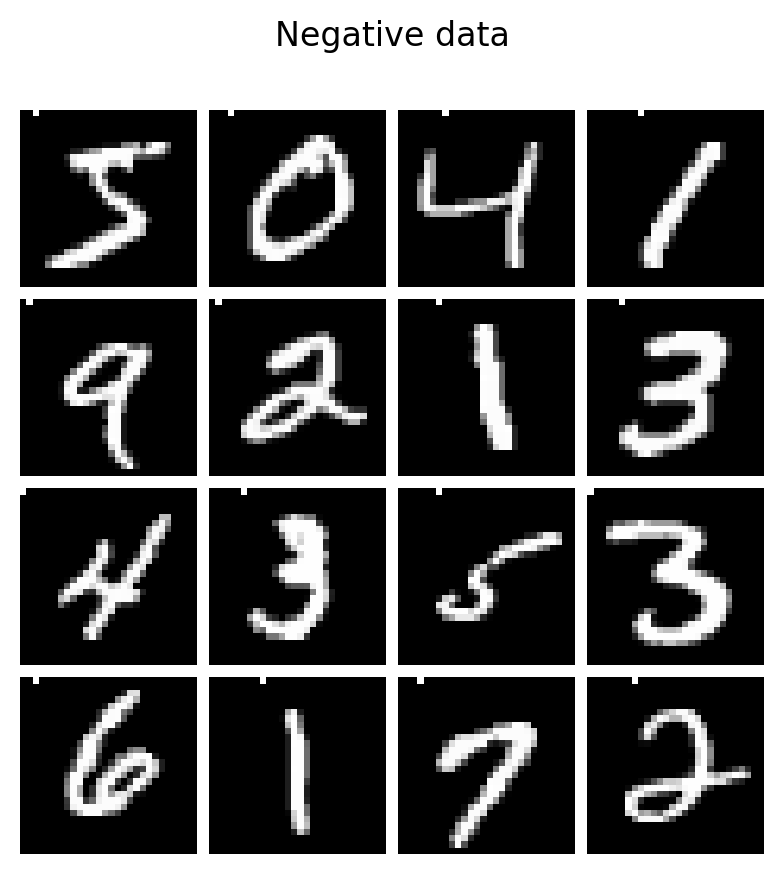

In [176]:
def derange(y, rng, max_iters):
    best_permuted_y = y
    best_n_deranged = 0
    for _ in range(max_iters):
        permuted_y = rng.permutation(y)
        n_deranged = (permuted_y != y).sum()
        if n_deranged > best_n_deranged:
            best_permuted_y = permuted_y
            best_n_deranged = n_deranged
    return permuted_y

y_train_concat = np.concatenate([y_train, y_train])
y_train_neg = derange(y_train_concat, np.random.default_rng(0), 10)  # more iters are not worth it

# remove positive labels and adjust size
neg_idxs = y_train_neg != y_train_concat
X_train_neg = np.concatenate([X_train, X_train])[neg_idxs]
X_train_neg = X_train_neg[:len(X_train)]
y_train_neg = y_train_neg[neg_idxs]
y_train_neg = y_train_neg[:len(y_train)]
X_train_neg = np_encode_class_in_image(X_train_neg, y_train_neg, len(dataset.classes))
del y_train_neg

X_train_neg, = unison_permute(X_train_neg, seed=3)

print(X_train_neg.shape)
tiles(X_train_neg[:16].reshape(4, 4, 28, 28), "Negative data")

In [38]:
NORMALIZATION_OFFSET = 1e-4

def normalize(x):
    return x / (jnp.linalg.norm(x) + NORMALIZATION_OFFSET)

In [109]:
[1, 2, *(i for sublayer in zip([6, 7, 8], [7,8, 9]) for i in sublayer) ]

[1, 2, 6, 7, 7, 8, 8, 9]

In [156]:
from functools import partial

class FFLayer(eqx.Module):
    layers: list

    def __init__(self, *layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class FFNetwork(eqx.Module):
    layers: list

    def __init__(self, key, sizes):
        keys = jax.random.split(key, len(sizes) - 1)
        self.layers = [
            FFLayer(
                normalize,
                jnp.ravel,
                eqx.nn.Linear(in_size, out_size, key=key),
                jax.nn.relu,
            )
            for key, in_size, out_size in zip(keys, sizes[:-1], sizes[1:])
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "500"]:
        for layer in self.layers:
            x = layer(x)
        return x

model = FFNetwork(
    key=jax.random.PRNGKey(0),
    sizes=[784, 512, 512],
)
print(model(X_dummy[0]).shape)
print(eqx.filter_vmap(model)(X_dummy).shape)

(512,)
(512, 512)


In [157]:
model

FFNetwork(
  layers=[
    FFLayer(
      layers=(
        <function normalize>,
        <wrapped function ravel>,
        Linear(
          weight=f32[512,784],
          bias=f32[512],
          in_features=784,
          out_features=512,
          use_bias=True
        ),
        <wrapped function relu>
      )
    ),
    FFLayer(
      layers=(
        <function normalize>,
        <wrapped function ravel>,
        Linear(
          weight=f32[512,512],
          bias=f32[512],
          in_features=512,
          out_features=512,
          use_bias=True
        ),
        <wrapped function relu>
      )
    )
  ]
)

In [158]:
def goodness_fn(x: Float[Array, "batch ..."]) -> Float[Array, "batch"]:
    return (x * x).reshape(x.shape[0], -1).mean(axis=-1)

In [159]:
@eqx.filter_jit
def loss_and_outputs(
    layer: FFLayer,
    x: Float[Array, "batch ..."],
    sgn: float,
    threshold: float,
) -> tuple[Float[Array, ""], Float[Array, "batch ..."]]:
    x = jax.vmap(layer)(x)
    g = sgn * (goodness_fn(x) - threshold)
    # g = jax.nn.sigmoid(g).mean()
    g = jax.nn.softplus(g).mean()
    return g, x

print(loss_and_outputs(model.layers[0], X_dummy, sgn=1, threshold=2)[0])
loss_and_outputs(model.layers[0], X_dummy, sgn=-1, threshold=2)[0]

0.12697439


Array(2.1265855, dtype=float32)

In [160]:
x = X_dummy

for layer in model.layers:
    loss_val, x = loss_and_outputs(layer, x, sgn=-1, threshold=2)
    print(loss_val, x.shape)

2.1265855 (512, 512)
2.1263354 (512, 512)


In [161]:
print(list(map(type,
    eqx.filter_grad(loss_and_outputs, has_aux=True)(
        model.layers[0], X_dummy, sgn=-1, threshold=5
    )
)))
print(list(map(type,
    eqx.filter_value_and_grad(loss_and_outputs, has_aux=True)(
        model.layers[0], X_dummy, sgn=-1, threshold=2
    )
)))

[<class '__main__.FFLayer'>, <class 'jaxlib.xla_extension.ArrayImpl'>]
[<class 'tuple'>, <class '__main__.FFLayer'>]


In [162]:
@eqx.filter_jit
def predict(
    model: FFNetwork,
    x: Float[Array, "batch 1 28 28"],
    num_classes: int = NUM_CLASSES,
) -> Float[Array, "batch num_classes"]:
    preds = jnp.zeros((x.shape[0], num_classes))
    layers = list(map(eqx.filter_vmap, model.layers))

    for label in jnp.arange(num_classes):
        t = jnp_encode_class_in_image(x, label, num_classes)
        t = layers[0](t)

        goodness = 0
        for layer in layers[1:]:
            t = layer(t)
            goodness += goodness_fn(t)
        goodness /= (len(layers) - 1)
        preds = preds.at[:, label].set(goodness)

    return preds

predict(model, X_dummy).shape

(512, 47)

In [163]:
def batch_predict(model, X, batch_size, num_classes=NUM_CLASSES):
    preds = jnp.zeros((X.shape[0], num_classes))

    for i, x in batch_data(X, batch_size=batch_size, enum=True):
        batch_preds = predict(model, x, num_classes)
        preds = preds.at[i:i+batch_size].set(batch_preds)

    return preds

batch_predict(model, X_test, BATCH_SIZE).shape

(18800, 47)

In [164]:
def compute_accuracy(model, x, y, num_classes=NUM_CLASSES):
    preds = predict(model, x, num_classes)
    pred_y = jax.nn.softmax(preds, axis=-1).argmax(axis=-1)
    return jnp.mean(y == pred_y)

compute_accuracy(model, X_dummy, y_dummy)

Array(0.03125, dtype=float32)

In [165]:
def evaluate(model, X_test, y_test, batch_size, num_classes=NUM_CLASSES):
    avg_accuracy = 0
    avg_goodness = 0
    n_batches = (len(X_test) + batch_size - 1) // batch_size

    for x, y in batch_data(X_test, y_test, batch_size=batch_size):
        preds = predict(model, x, num_classes)
        pred_y = jax.nn.softmax(preds, axis=-1).argmax(axis=-1)
        goodness = preds[jnp.arange(preds.shape[0]), pred_y]
        avg_goodness += goodness.mean()
        avg_accuracy += jnp.mean(y == pred_y)

    avg_goodness /= n_batches
    avg_accuracy /= n_batches
    return avg_goodness, avg_accuracy

evaluate(model, X_test, y_test, batch_size=BATCH_SIZE)

(Array(0.00068205, dtype=float32), Array(0.02398373, dtype=float32))

In [166]:
class Metrics(eqx.Module):
    pos_goodness: list
    neg_goodness: list
    train_accuracy: list
    test_goodness: list
    test_accuracy: list

    def __init__(self, *, pos_goodness=[], neg_goodness=[], train_accuracy=[], test_goodness=[], test_accuracy=[]):
        self.pos_goodness = pos_goodness
        self.neg_goodness = neg_goodness
        self.train_accuracy = train_accuracy
        self.test_goodness = test_goodness
        self.test_accuracy = test_accuracy

    def update(self, *, pos_goodness=None, neg_goodness=None, train_accuracy=None, test_goodness=None, test_accuracy=None):
        return Metrics(
            pos_goodness=self.pos_goodness + ([pos_goodness] if pos_goodness else []),
            neg_goodness=self.neg_goodness + ([neg_goodness] if neg_goodness else []),
            train_accuracy=self.train_accuracy + ([train_accuracy] if train_accuracy else []),
            test_goodness=self.test_goodness + ([test_goodness] if test_goodness else []),
            test_accuracy=self.test_accuracy + ([test_accuracy] if test_accuracy else []),
        )

In [167]:
from copy import deepcopy

def train(
    model: FFNetwork,
    optims: list[optax.GradientTransformation],
    opt_states,
    *,
    threshold: float,
    batch_size: int,
    epochs: int,
    print_every: int,
    metrics: Metrics,
):
    n_batches = (len(X_train) + batch_size - 1) // batch_size
    metrics = deepcopy(metrics)

    @eqx.filter_jit
    def make_substep(layer, opt_state, optim, x, sgn):
        grads, x = eqx.filter_grad(loss_and_outputs, has_aux=True)(
            layer, x, sgn=sgn, threshold=threshold
        )
        updates, opt_state = optim.update(grads, opt_state, layer)
        layer = eqx.apply_updates(layer, updates)

        return layer, opt_state, x

    def make_step(model, opt_states, x_pos, x_neg):
        pos_goodness = neg_goodness = 0

        for i, (layer, opt_state, optim) in enumerate(zip(model.layers, opt_states, optims)):
            layer, opt_state, x_pos = make_substep(layer, opt_state, optim, x_pos, sgn=-1.)
            layer, opt_state, x_neg = make_substep(layer, opt_state, optim, x_neg, sgn=1.)

            model = eqx.tree_at(lambda m: m.layers[i], model, layer)
            opt_states = eqx.tree_at(lambda o: o[i], opt_states, opt_state)

            pos_goodness += goodness_fn(x_pos).mean()
            neg_goodness += goodness_fn(x_neg).mean()

        pos_goodness /= len(model.layers)
        neg_goodness /= len(model.layers)

        return model, opt_states, pos_goodness, neg_goodness


    try:
        for epoch in range(epochs):
            avg_pos_goodness = avg_neg_goodness = 0

            for x_pos, x_neg in batch_data(
                X_train_pos, X_train_neg,
                shorten=False, batch_size=batch_size
            ):
                model, opt_states, pos_goodness, neg_goodness = make_step(
                    model, opt_states, x_pos, x_neg
                )

                avg_pos_goodness += pos_goodness
                avg_neg_goodness += neg_goodness

            avg_pos_goodness = avg_pos_goodness / n_batches
            avg_neg_goodness = avg_neg_goodness / n_batches
            metrics = metrics.update(
                pos_goodness=avg_pos_goodness.item(),
                neg_goodness=avg_neg_goodness.item(),
            )

            if (epoch + 1) % print_every == 0:
                _, train_accuracy = evaluate(model, X_train, y_train, batch_size)
                test_goodness, test_accuracy = evaluate(model, X_test, y_test, batch_size)
                metrics = metrics.update(
                    train_accuracy=train_accuracy.item(),
                    test_goodness=test_goodness.item(),
                    test_accuracy=test_accuracy.item(),
                )
                print(
                    f"[{epoch + 1:3d}] train_pos_goodness={avg_pos_goodness:10.3f} "
                    f"train_neg_goodness={avg_neg_goodness:10.3f} "
                    f"train_accuracy={train_accuracy:8.5f} "
                    f"test_goodness={test_goodness:10.3f} "
                    f"test_accuracy={test_accuracy:8.5f} "
                )
    except KeyboardInterrupt:
        pass

    return model, opt_states, metrics

In [168]:
THRESHOLD = 10.
BATCH_SIZE = 512
LEARNING_RATE = 0.05
EPOCHS = 100
PRINT_EVERY = 1

layer_sizes = [784, 1024, 1024]
optim_cls = optax.adam

experiment_id = (
    f"EMNIST-{type(dataset).__name__}_"
    f"{'-'.join(map(str, layer_sizes))}_"
    f"{optim_cls.__name__}-{LEARNING_RATE}_"
    f"thr-{THRESHOLD}_"
    f"bs-{BATCH_SIZE}"
)
experiment_id

'EMNIST-Balanced_784-1024-1024_adam-0.05_thr-10.0_bs-512'

In [169]:
metrics = Metrics()

model = FFNetwork(
    key=jax.random.PRNGKey(0),
    sizes=layer_sizes,
)

optims = [optax.adam(LEARNING_RATE) for _ in range(len(model.layers))]
opt_states = [optim.init(eqx.filter(layer, eqx.is_array))
              for optim, layer in zip(optims, model.layers)]

trained_model, trained_opt_states, trained_metrics = train(
    model, optims, opt_states, metrics=metrics,
    threshold=THRESHOLD, batch_size=BATCH_SIZE,
    epochs=EPOCHS, print_every=PRINT_EVERY
)

[  1] train_pos_goodness=     9.657 train_neg_goodness=     9.963 train_accuracy= 0.02246 test_goodness=     9.896 test_accuracy= 0.02187 
[  2] train_pos_goodness=     9.896 train_neg_goodness=     9.998 train_accuracy= 0.00621 test_goodness=    10.226 test_accuracy= 0.00632 
[  3] train_pos_goodness=    10.029 train_neg_goodness=     9.898 train_accuracy= 0.02360 test_goodness=    10.571 test_accuracy= 0.02472 
[  4] train_pos_goodness=    10.168 train_neg_goodness=     9.752 train_accuracy= 0.02423 test_goodness=    10.829 test_accuracy= 0.02631 
[  5] train_pos_goodness=    10.295 train_neg_goodness=     9.609 train_accuracy= 0.02903 test_goodness=    11.097 test_accuracy= 0.02986 
[  6] train_pos_goodness=    10.453 train_neg_goodness=     9.422 train_accuracy= 0.03726 test_goodness=    11.221 test_accuracy= 0.04052 
[  7] train_pos_goodness=    10.608 train_neg_goodness=     9.237 train_accuracy= 0.07403 test_goodness=    11.322 test_accuracy= 0.07481 
[  8] train_pos_goodness=  

In [23]:
# trained_model, trained_opt_states, trained_metrics = train(
#     trained_model, optims, trained_opt_states, metrics=trained_metrics,
#     threshold=0.5*THRESHOLD, batch_size=BATCH_SIZE,
#     epochs=EPOCHS, print_every=PRINT_EVERY
# )

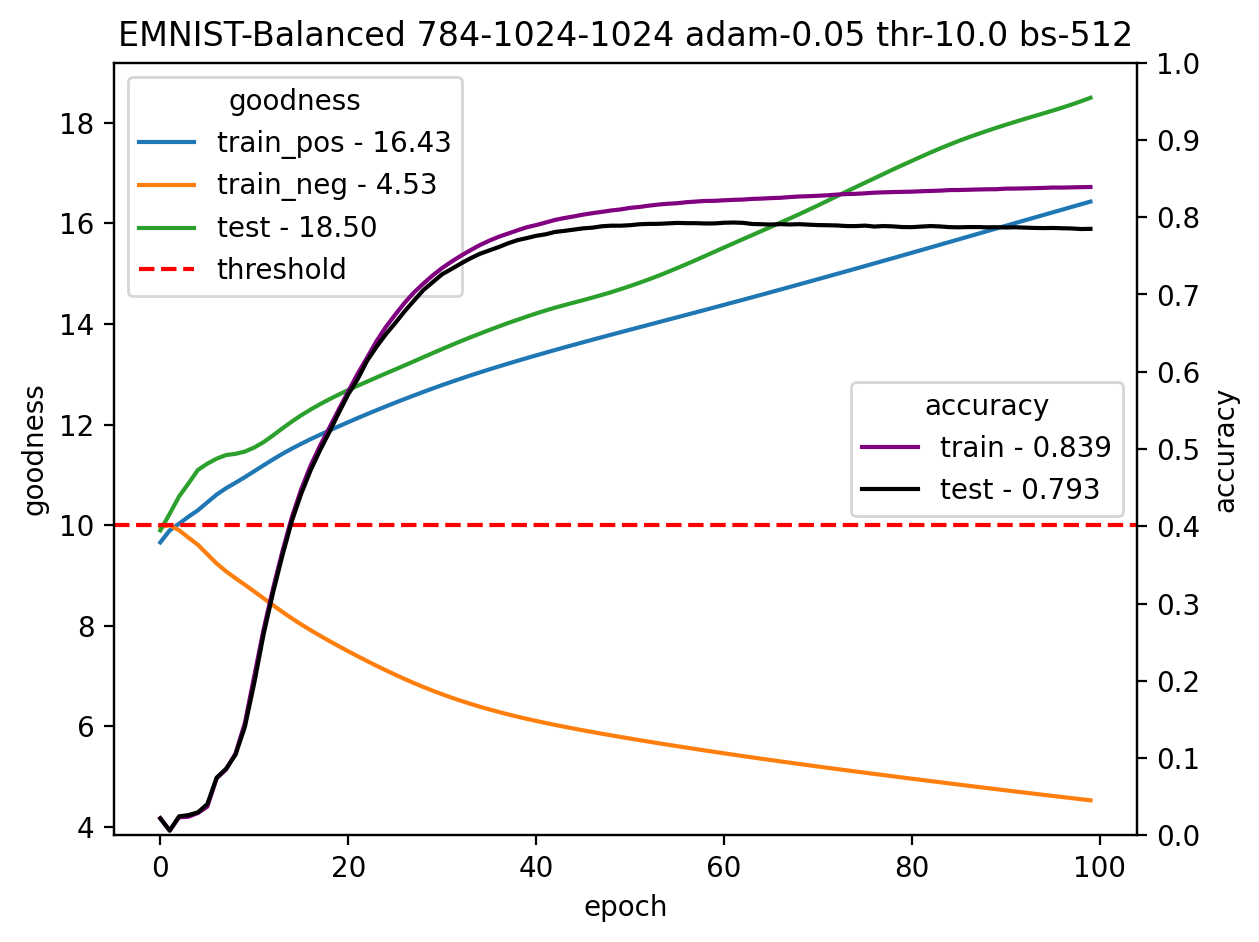

In [170]:
metrics = trained_metrics

fig, ax1 = plt.subplots()

ax1.set_xlabel('epoch')
ax1.set_ylabel('goodness')
ax1.plot(metrics.pos_goodness, label=f'train_pos - {max(metrics.pos_goodness):.2f}')
ax1.plot(metrics.neg_goodness, label=f'train_neg - {min(metrics.neg_goodness):.2f}')
ax1.plot(metrics.test_goodness, label=f'test - {max(metrics.test_goodness):.2f}')
ax1.axhline(THRESHOLD, linestyle='--', label='threshold', color='red')
ax1.tick_params(axis='y')
ax1.legend(title='goodness', loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('accuracy')
ax2.plot(metrics.train_accuracy, color='purple', label=f'train - {max(metrics.train_accuracy):.3f}')
ax2.plot(metrics.test_accuracy, color='black', label=f'test - {max(metrics.test_accuracy):.3f}')
ax2.tick_params(axis='y')
ax2.legend(title='accuracy', loc='center right')
ax2.set_ylim([0., 1.])
ax2.set_yticks(list(np.linspace(0., 1., 11)))

plt.title(experiment_id.replace('_', ' '))

fig.tight_layout()
fig.savefig(f'{experiment_id}.svg', dpi=300)
fig.savefig(f'{experiment_id}.png', dpi=300)

In [25]:
# import json

# with open(f"{experiment_id}.json", "w") as f:
#     json.dump(metrics, f)

In [26]:
# def save_model(filename, metrics, model, opt_states):
#     with open(filename, "wb") as f:
#         f.write((json.dumps(metrics) + "\n").encode())
#         eqx.tree_serialise_leaves(f, model)
#         eqx.tree_serialise_leaves(f, opt_states)

# save_model(f'{experiment_id}.eqx',
#            metrics, trained_model, trained_opt_states)

In [27]:
# def load_model(filename):
#     with open(filename, "b") as f:
#         new_metrics = json.loads(f.readling().decode())
#         new_model = None